## Import library yang dibutuhkan

In [107]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import nltk
from nltk.corpus import stopwords
import re

## Me-load dataset yang akan digunakan

In [108]:
df = pd.read_csv('Suicide_Ideation_Dataset(Twitter-based).csv')
df

,Tweet,Suicide
0,making some lunch,Not Suicide post
1,@Alexia You want his money.,Not Suicide post
2,@dizzyhrvy that crap took me forever to put to...,Potential Suicide post
3,@jnaylor #kiwitweets Hey Jer! Since when did y...,Not Suicide post
4,Trying out &quot;Delicious Library 2&quot; wit...,Not Suicide post
...,...,...
1782,i have forgotten how much i love my Nokia N95-1,Not Suicide post
1783,Starting my day out with a positive attitude! ...,Not Suicide post
1784,"@belledame222 Hey, it's 5 am...give a girl som...",Not Suicide post
1785,2 drunken besties stumble into my room and we ...,Not Suicide post


## Convert label menjadi dalam representasi angka

Untuk tweet yang berlabel "Potential Suicide post" akan direpresentasikan dengan angka 1, sedangkan untuk label "Not Suicide post" akan direpresentasikan dengan angka 0.

In [109]:
unique_suicide = df['Suicide'].unique()
unique_suicide

array(['Not Suicide post', 'Potential Suicide post '], dtype=object)

In [110]:
df['Suicide'] = df['Suicide'].str.strip()

In [111]:
df['Suicide'] = df['Suicide'].map({'Potential Suicide post': 1, 'Not Suicide post': 0})

In [112]:
df

,Tweet,Suicide
0,making some lunch,0
1,@Alexia You want his money.,0
2,@dizzyhrvy that crap took me forever to put to...,1
3,@jnaylor #kiwitweets Hey Jer! Since when did y...,0
4,Trying out &quot;Delicious Library 2&quot; wit...,0
...,...,...
1782,i have forgotten how much i love my Nokia N95-1,0
1783,Starting my day out with a positive attitude! ...,0
1784,"@belledame222 Hey, it's 5 am...give a girl som...",0
1785,2 drunken besties stumble into my room and we ...,0


## Data preprocessing

### Menghapus username (mention) dan link

In [113]:
def remove_usernames_and_links(text):
    if isinstance(text, str):
        # Menghapus username yang diawali dengan @
        text = re.sub(r'@[\w]+', '', text)
        # Menghapus tautan yang dimulai dengan http atau https
        text = re.sub(r'http[s]?://\S+', '', text)
        return text
    else:
        return text  # Jika bukan string, kembalikan nilai asli

df['Tweet'] = df['Tweet'].apply(remove_usernames_and_links)

### Melakukan lowercase ke semua karakter

In [114]:
# Melakukan lowercase pada dataset
df['Tweet'] = df['Tweet'].str.lower()

### Menghapus tanda baca dan karakter spesial, serta konversi beberapa tanda baca lain

In [115]:
# Menghapus tanda baca dan karakter spesial
# Meng-convert karakter "%20" menjadi spasi
df['Tweet'] = df['Tweet'].str.replace('%20', ' ')
df['Tweet'] = df['Tweet'].str.replace('&quot;', '"')
df['Tweet'] = df['Tweet'].apply(lambda x: ''.join(char for char in str(x) if (char.isalnum() or char.isspace())) if isinstance(x, str) else x)

### Menghapus stopwords

In [116]:
# Menghapus stopwords
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

def remove_stopwords(text):
    if isinstance(text, str):
        words = text.split()
        filtered_words = [word for word in words if word.lower() not in stopwords]
        return ' '.join(filtered_words)
    else:
        return ''

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [117]:
df['Tweet'] = df['Tweet'].apply(remove_stopwords)

### Sneak peek data setelah di-preprocessing

In [118]:
df

,Tweet,Suicide
0,making lunch,0
1,want money,0
2,crap took forever put together iâm going go sl...,1
3,kiwitweets hey jer since start twittering,0
4,trying delicious library 2 mixed results bar c...,0
...,...,...
1782,forgotten much love nokia n951,0
1783,starting day positive attitude great watch gre...,0
1784,hey 5 amgive girl credit trying,0
1785,2 drunken besties stumble room run around sobe...,0


## Melihat frekuensi yang terdapat pada label.

<Axes: xlabel='Suicide'>

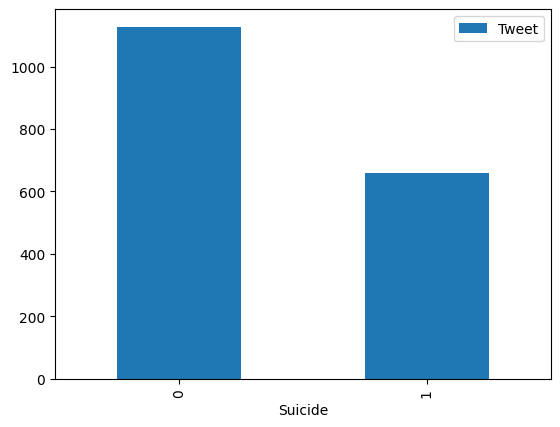

In [119]:
df.groupby('Suicide').count().plot.bar()

## Split dataset menjadi train dan test

In [120]:
X = df['Tweet'].values
y = df['Suicide'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## Mendefinisikan class dataset

Membuat class yang menjadi representasi Tweet.

In [121]:
class TweetDataset(Dataset):
    def __init__(self, tweets, labels, tokenizer, max_len):
        self.tweets = tweets
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, idx):
        tweet = str(self.tweets[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            tweet,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'tweet_text': tweet,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)  # Perubahan tipe data di sini
        }

In [122]:
def create_data_loader(X, y, tokenizer, max_len, batch_size):
    dataset = TweetDataset(tweets=X, labels=y, tokenizer=tokenizer, max_len=max_len)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [123]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MAX_LEN = 160
BATCH_SIZE = 8
EPOCHS = 3
accumulation_steps = 4

## Mendefinisikan model dan tokenizer

In [124]:
# Initialize tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
model = model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [125]:
train_data_loader = create_data_loader(X_train, y_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(X_val, y_val, tokenizer, MAX_LEN, BATCH_SIZE)

## Mendefinisikan optimizer

In [126]:
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [127]:
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [128]:
criterion = nn.CrossEntropyLoss().to(device)  # Menggunakan CrossEntropyLoss

## Melakukan training pada model

In [129]:
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    optimizer.zero_grad()
    for i, d in enumerate(train_data_loader):
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = criterion(logits, labels)  # Menggunakan CrossEntropyLoss dengan logits dan labels

        loss = loss / accumulation_steps
        loss.backward()

        if (i + 1) % accumulation_steps == 0:
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        total_loss += loss.item() * accumulation_steps

    avg_train_loss = total_loss / len(train_data_loader)

    # Validation step
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for d in val_data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits.squeeze()
            val_loss = criterion(logits, labels)

            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_data_loader)

    print(f"Epoch {epoch + 1}, Loss: {avg_train_loss}, Val Loss: {avg_val_loss}")

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch 1, Loss: 0.3780575819708948, Val Loss: 0.17570477041105428
Epoch 2, Loss: 0.11006292867260939, Val Loss: 0.18808125127106906
Epoch 3, Loss: 0.048816792609679964, Val Loss: 0.22202749045358763


## Melakukan evaluasi

In [132]:
from sklearn.metrics import accuracy_score

# Menghitung akurasi
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for d in val_data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Ambil indeks kelas dengan nilai logit tertinggi
        predictions = torch.argmax(logits, dim=1)

        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Hitung akurasi dengan accuracy_score dari scikit-learn
accuracy = accuracy_score(all_labels, all_predictions)
print("Accuracy:", accuracy)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Accuracy: 0.9413407821229051


## Fungsi untuk melakukan prediksi dari input user

In [133]:
def predict(text, model, tokenizer, max_len, device):
    # Tokenisasi input string
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_len,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt',
    )

    # Input tensor
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    # Prediksi menggunakan model
    model.eval()
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

    # Ambil indeks kelas dengan nilai logit tertinggi
    predicted_class = torch.argmax(logits, dim=1).item()

    return predicted_class

In [144]:
text = "you go to heaven!!!!"
predicted_class = predict(text, model, tokenizer, MAX_LEN, device)
if predicted_class == 0:
  print("Predicted class:", "Not Suicidal Tweet")
else:
  print("Predicted class:", "Potential Suicidal Tweet")

Predicted class: Not Suicidal Tweet


## Menyimpan model

In [141]:
# Menyimpan model dan tokenizer
model.save_pretrained('./model')
tokenizer.save_pretrained('./tokenizer')

('./tokenizer/tokenizer_config.json',
 './tokenizer/special_tokens_map.json',
 './tokenizer/vocab.txt',
 './tokenizer/added_tokens.json')